<a href="https://colab.research.google.com/github/jofernandezz/InteligenciaArtificial/blob/main/Clase3_MNIST(SGD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 5.9MB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
     |████████████████████████████████| 12.8MB 423kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *
matplotlib.rc('image', cmap='Greys')

Esta clase está basada en el capítulo 4 del libro [Deep Learning for Coders with fastai and PyTorch (Jeremy Howard, Sylvain Gugger)](https://www.oreilly.com/library/view/deep-learning-for/9781492045519/).

## Tras bambalinas: Entrenando un Clasificador de Dígitos

Para esta demostración solo crearemos un modelo que pueda clasificar una imagen como un 3 o un 7. Así que descarguemos una muestra de [MNIST](http://yann.lecun.com/exdb/mnist/) que contiene imágenes de solo esos dígitos:

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

El dataset MNIST sigue un diseño común para Machine Learning: carpetas separadas para el conjunto de entrenamiento y el conjunto de validación (y/o conjunto de prueba). Veamos qué hay dentro del conjunto de entrenamiento:


In [ ]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

Hay una carpeta para los 3 y otra para los 7. En jerga de machine learning decimos que "3" y "7" son las etiquetas del dataset. Miremos lo que hay en estos directorios:

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

Como se esperaba, están llenos de imágenes de números. Miremos una en particular:

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

En computación todo se representa como un número. Para ver los números que componen esta imagen, tenemos que convertirla en una matriz NumPy o un tensor PyTorch. Por ejemplo, así es como se ve una sección de la imagen, convertida en una matriz NumPy:


In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

El 4:10 indica que solicitamos las filas del índice 4 (incluido) al 10 (no incluido) y lo mismo para las columnas. NumPy indexa de arriba a abajo y de izquierda a derecha, por lo que esta sección se encuentra en la esquina superior izquierda de la imagen. Para lo mismo para un tensor de PyTorch:


In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

Podemos cortar la matriz para elegir solo la parte superior del dígito, y luego usar un Pandas DataFrame para codificar por colores los valores usando un degradado, que nos muestra claramente cómo se crea la imagen a partir de los valores de píxeles:

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Podemos ver que los píxeles blancos del fondo se almacenan con el número 0, el negro es el número 255 y los tonos de gris están entre los dos. La imagen completa contiene 28 píxeles de ancho y 28 píxeles de profundidad, para un total de 784 píxeles. Obvio que es un tamaño mucho más pequeño que una imagen que obtendría la cámara de un teléfono, que tiene millones de píxeles, pero tiene un tamaño conveniente para lo que queremos aprender ahora.


Entonces ahora que hemos visto cómo se ve una imagen en un computador, recordemos nuestro objetivo: crear un modelo que pueda reconocer 3 y 7. ¿Cómo podríamos conseguir que un computador haga eso?

## Primer Intento: Similaridad de Píxeles

Aquí una primera idea: ¿qué tal si encontramos el valor de píxel promedio para cada píxel de los 3 y luego hacemos lo mismo con los 7? Esto nos dará dos promedios de grupo, definiendo lo que podríamos llamar los 3 y 7 "ideales". Luego, para clasificar una imagen como un dígito u otro, vemos cuál de estos dos dígitos ideales es más similar a la imagen. Esta metodología parece lógica y debería ser mejor que tener nada, por lo que se dice que será una buena línea de base (**baseline**).

Baseline: Es un modelo simple del que estamos seguros que se desempeñara razonablemente bien. Debe ser fácil de implementar y fácil de probar cosa de poder compararlo contra cualquier idea nueva y cerciorarnos que es mejor que esta línea base.

El primer paso de nuestro modelo simple es obtener el promedio de los valores de píxeles para cada uno de nuestros dos grupos. 

Crearemos un tensor que contenga todos nuestros 3 apilados juntos. Ya sabemos cómo crear un tensor que contenga una sola imagen. Para crear un tensor que contenga todas las imágenes en un directorio, primero usaremos una lista de comprensión de Python para crear una lista simple de los tensores de una sola imagen.

Usaremos Jupyter para hacer algunas pequeñas verificaciones de nuestro trabajo a lo largo del camino, en este caso, asegurándonos de que la cantidad de artículos devueltos parezca razonable:

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

También comprobemos que las imágenes se vean bien. Dado que ahora tenemos tensores (que Jupyter por defecto imprimirá como valores), en lugar de imágenes PIL (que Jupyter por defecto mostrará como imágenes), necesitamos usar la función `show_image` de fastai para mostrarlo:

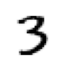

In [ ]:
show_image(three_tensors[1]);

Para cada posición de píxel queremos calcular el promedio de todas  las intensidad del pixel en el conjunto imágenes. Para hacer esto, primero combinamos todas las imágenes de esta lista en un solo tensor tridimensional. La forma más común de describir tal tensor es llamarlo *tensor de rango 3*. A menudo necesitamos apilar tensores individuales en una colección en un solo tensor. Como era de esperar, PyTorch viene con una función llamada `stack` (pila) que podemos usar para este propósito.

Algunas operaciones en PyTorch, como tomar una media, nos requieren *convertir* nuestros tipos enteros a tipos flotantes. Como necesitaremos esto más adelante, también convertiremos nuestro tensor apilado para que sea un float. Hacer esta conversión (casting) en PyTorch es tan simple como escribir el nombre del tipo al que desea convertir y tratarlo como un método.

Generalmente, cuando las imágenes son floats, se espera que los valores de los píxeles estén entre 0 y 1, por lo que también dividiremos por 255:

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Quizás el atributo más importante de un tensor es su *forma* (shape). Nos indica la longitud de cada eje. En este caso, podemos ver que tenemos 6.131 imágenes, cada una de tamaño 28 × 28 píxeles. No hay nada específicamente en este tensor que diga que el primer eje es el número de imágenes, el segundo es la altura y el tercero es el ancho; la semántica de un tensor depende completamente de nosotros y de cómo lo construimos. En lo que respecta a PyTorch, es solo un montón de números en la memoria.

La *longitud* de la forma de un tensor es su rango:

In [ ]:
len(stacked_threes.shape)

3

In [ ]:
stacked_threes.ndim

3

Es muy importante recordar para el futuro estos conceptos de la jerga tensorial: _rank_ (rango) es el número de ejes o dimensiones en un tensor; _shape_ (forma) es el tamaño de cada eje de un tensor.

Finalmente, podemos calcular cómo se ve el 3 ideal. Calculamos la media de todos los tensores de imagen tomando la media a lo largo de la dimensión 0 de nuestro tensor de rango 3 apilado. Esta es la dimensión que indexa todas las imágenes.

En otras palabras: para cada posición de píxel se calculará el promedio de ese píxel en todas las imágenes. El resultado será un valor para cada posición de píxel, es decir nos entregará una sola imagen.

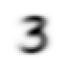

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

Según este conjunto de datos, ¡este es el número 3 ideal! Se puede ver cómo es más oscuro en los píxeles donde todas las imágenes coinciden en que debería estar oscuro, pero se vuelve tenue y borroso donde las imágenes en general no coinciden.

Hagamos lo mismo con los 7:

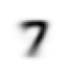

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Ahora veamos un ejemplo de un 3:

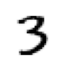

In [ ]:
a_3 = stacked_threes[1]
show_image(a_3);

¿Cómo podemos determinar su distancia de nuestro 3 ideal? No podemos simplemente sumar las diferencias entre los píxeles de esta imagen y el dígito ideal. Algunas diferencias serán positivas mientras que otras serán negativas, y esas diferencias se cancelarían, dando como resultado una situación en la que una imagen que es demasiado oscura en algunos lugares y demasiado clara en otros puede mostrarse como que tiene cero diferencias totales con respecto al ideal. ¡Eso sería engañoso!

Para evitar esto, hay dos formas recomendadas para medir la distancia en este contexto:

- Tomar la media del *valor absoluto* de las diferencias (el valor absoluto es la función que reemplaza los valores negativos con valores positivos). Esto se llama *diferencia absoluta media* o *norma L1*

- Tomar la media del *cuadrado* de las diferencias (que hace que todo sea positivo) y luego sacar la *raíz cuadrada* (que deshace el cuadrado). Esto se denomina *error cuadrático medio* (RMSE) o *norma L2*.

Probemos ambas distancias:

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

En ambos casos, la distancia entre este 3 y el 3 ideal es menor que la distancia al 7 ideal. Es decir que nuestro modelo simple dará la predicción correcta en este caso.

PyTorch ya proporciona ambos distancias como funciones de pérdida (loss). Se encuentran dentro de torch.nn.functional, que la documentación de PyTorch recomienda importar como F (y está disponible de forma predeterminada con ese nombre en fastai):

In [ ]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Aquí `mse` significa *error cuadrático medio*, y` l1` se refiere a la jerga matemática estándar para *valor absoluto medio* (en matemáticas se llama la *norma L1*).

## Calculando métricas usando Broadcasting

Una métrica es un número que se calcula en función de las predicciones de nuestro modelo y las etiquetas correctas en nuestro dataset para decirnos qué tan bueno es nuestro modelo. Por ejemplo, podríamos usar cualquiera de las funciones que vimos en la sección anterior, el error cuadrático medio o el error absoluto medio, y tomar el promedio de ellas en todo el conjunto de datos. Sin embargo, ninguno de estos números es comprensibles para la mayoría de la gente; en la práctica, normalmente usamos la *exactitud* (accuracy) como métrica para los modelos de clasificación.

Como hemos comentado anteriormente, queremos calcular nuestra métrica sobre un *conjunto de validación*. Esto es para que no sobreajustemos (overfit), es decir, entrenemos un modelo para que funcione bien solo en nuestros datos de entrenamiento. Esto no es realmente un riesgo con el modelo de similitud de píxeles que estamos usando aquí como primer intento, ya que no tiene componentes entrenados, pero usaremos un conjunto de validación de todos modos para seguir las prácticas normales de la disciplina.

Para obtener un conjunto de validación, debemos eliminar algunos de los datos del entrenamiento por completo, para que el modelo no los vea en absoluto al ajustar sus parámetros. Resulta que los creadores del conjunto de datos MNIST ya lo han hecho por nosotros. ¿Recuerdan cómo había un directorio completamente separado llamado *valid*? ¡Para eso es esa carpeta!

Entonces creemos tensores para nuestros 3 y 7 a partir de ese directorio. Estos son los tensores que usaremos para calcular una métrica que mide la calidad de nuestro modelo de línea base, que mide la distancia a una imagen ideal:

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Es bueno adquirir el hábito de comprobar las formas de los tensores sobre la marcha. Aquí vemos dos tensores, uno que representa el conjunto de validación de 3 de 1010 imágenes de tamaño 28 × 28 y otro que representa el conjunto de validación de 7 de 1028 imágenes de tamaño 28 × 28.

Ahora queremos escribir una función, `is_3`, que decidirá si una imagen arbitraria es un 3 o un 7. Lo hará decidiendo a cuál de nuestros dos "dígitos ideales" está más cerca esta imagen arbitraria. Para eso, necesitamos definir una noción de distancia, es decir, una función que calcula la distancia entre dos imágenes.

Podemos escribir una función simple que calcule el error absoluto medio usando una expresión muy similar a la que escribimos en la última sección:

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

Este es el mismo valor que calculamos previamente para la distancia entre estas dos imágenes, el 3 ideal `mean3` y la muestra arbitraria 3 `a_3`, que recordemos son tensores de una sola imagen con una forma de [28,28].

Pero para calcular una métrica para la exactitud general, necesitaremos calcular la distancia al 3 ideal para cada imagen en el conjunto de validación. ¿Cómo hacemos ese cálculo? Podríamos escribir un bucle (loop) sobre todos los tensores de una sola imagen que están apilados dentro de nuestro tensor de conjunto de validación, `valid_3_tens`, que tiene una forma de [1010,28,28] que representa 1010 imágenes. Pero hay una mejor manera.

Algo muy interesante sucede cuando tomamos exactamente la misma función de distancia, diseñada para comparar dos imágenes individuales, pero pasamos como argumento `valid_3_tens`, el tensor que representa el conjunto de validación de 3:

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1294, 0.1213, 0.1086,  ..., 0.1116, 0.1150, 0.1219]),
 torch.Size([1010]))

En lugar de quejarse de que las formas no coinciden, devolvió la distancia para cada imagen como un vector (es decir: un tensor de rango 1) de longitud 1010 (el número de 3 en nuestro conjunto de validación). ¿Cómo ocurrió eso?

Echemos un vistazo a nuestra función `mnist_distance` y veamos que tenemos la resta `(a-b)`. El truco de magia es que PyTorch, cuando intenta realizar una simple operación de resta entre dos tensores de diferentes rangos, usará algo llamado *broadcasting*. Eso quiere decir que expandirá automáticamente el tensor con el rango más pequeño para que tenga el mismo tamaño que el que tiene el rango más grande. El broadcasting hace entonces que el código tensorial sea mucho más fácil de escribir.

Después del broadcasting para que los dos tensores de argumento tengan el mismo rango, PyTorch aplica su lógica habitual para dos tensores del mismo rango: realiza la operación en cada elemento correspondiente de los dos tensores y devuelve el resultado del tensor. Por ejemplo:

In [ ]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

Entonces, en el caso de nuestras métrica, PyTorch trata `mean3`, un tensor de rango 2 que representa una sola imagen, como si fueran 1010 copias de la misma imagen y luego resta cada una de esas copias de cada 3 en nuestro conjunto de validación. ¿Qué forma esperaríamos que tuviera este tensor?

In [ ]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

Podemos usar `mnist_distance` para averiguar si una imagen es un 3 o no usando la siguiente lógica: si la distancia entre el dígito en cuestión y el 3 ideal es menor que la distancia al 7 ideal, entonces es un 3. Esta función hará el broadcasting automáticamente y se aplicará por elementos, al igual que todas las funciones y operadores de PyTorch:

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Probemos en la imagen arbitraria que habíamos seleccionado:

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Notemos que cuando convertimos la respuesta *bool* a un *float* obtenemos un `1.0` para `True` y un `0.0` para  `False`. Gracias al broadcasting podemos aplicarlo a todo el conjunto de validación de 3:

In [ ]:
is_3(valid_3_tens)

tensor([ True, False,  True,  ...,  True,  True,  True])

Ahora podemos calcular la exactitud de cada 3 y 7 tomando el promedio de la función para todos los 3 y su inverso para todos los 7:

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

¡Parece un buen comienzo! Estamos obteniendo más del 90% de exactitud tanto en 3 como en 7, y hemos visto cómo definir una métrica de manera conveniente mediante el broadcasting.

Pero seamos honestos: 3 y 7 son dígitos de aspecto muy diferente. Y solo estamos clasificando 2 de los 10 dígitos posibles hasta ahora. ¡Así que tendremos que hacerlo mejor!

Para hacerlo mejor, tal vez sea el momento de probar un sistema que aprenda de verdad, es decir, que pueda modificarse automáticamente para mejorar su rendimiento. En otras palabras, es hora de hablar sobre el proceso de entrenamiento y el SGD.

## Motivación al SGD (gradiente descendente estocástico)

En lugar de tratar de encontrar la similitud entre una imagen y una "imagen ideal", podríamos mirar cada píxel individual y obtener un conjunto de pesos para cada uno, de modo que los pesos más altos estén asociados con los píxeles con mayor probabilidad de ser negro para una categoría en particular. Por ejemplo, es poco probable que los píxeles hacia la parte inferior derecha se activen para un 7, por lo que deberían tener un peso bajo para un 7 en esa zona, pero es probable que se activen para un 8, por lo que deberían tener un peso alto para un 8. Esto se puede representar como una función y un conjunto de valores de peso para cada categoría posible, por ejemplo, la probabilidad de ser el número 8:

`def pr_eight(x,w): return (x*w).sum()`

Aquí asumimos que `x` es la imagen, representada como un vector; en otras palabras, con todas las filas apiladas de punta a punta en una sola línea larga. Y estamos asumiendo que los pesos son un vector `w`. Si tenemos esta función, entonces solo necesitamos alguna forma de actualizar los pesos para mejorarlos un poco. Con este enfoque, podemos repetir ese paso varias veces, haciendo que los pesos sean cada vez mejores, hasta que sean tan buenos como sea posible.

Queremos encontrar los valores específicos para el vector `w` que hace que el resultado de nuestra función sea alto para aquellas imágenes que en realidad son 8s y bajo para aquellas imágenes que no lo son. La búsqueda del mejor vector `w` es una forma de buscar la mejor función para reconocer 8s.

Para ser más específicos, estos son los pasos que vamos a requerir para convertir esta función en un clasificador de machine learning:

1. *Inicialicemos* los pesos.
1. Para cada imagen, usemos estos pesos para *predecir* si parece ser un 3 o un 7.
1. Con base en estas predicciones, calculemos qué tan bueno es el modelo (su *pérdida* o *loss*).
1. Calculemos el *gradiente*, que mide para cada peso, cómo cambiar ese peso incide en nuestro valor de pérdida
1. Relizar un *Paso* (*Step*) para cambiar todos los pesos basados ​​en ese cálculo.
1. Volvemos al paso 2 y *repitimos* el proceso.
1. Repitimos hasta que decidamos *detener* el proceso de entrenamiento (por ejemplo, porque el modelo es lo suficientemente bueno o no queremos seguir esperando).

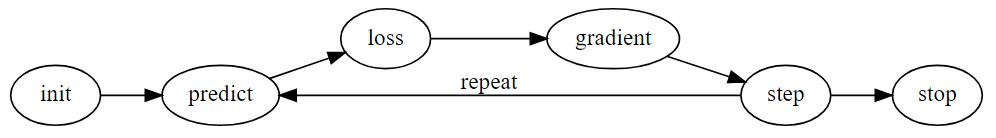

Antes de aplicar estos pasos a nuestro problema de clasificación de imágenes, ilustremos cómo se desarrollarían en un caso más simple. Primero definiremos una función muy simple, la cuadrática; supongamos que esta es nuestra función de pérdida, y `x` es un parámetro de ponderación de la función:

In [ ]:
def f(x): return x**2

Este sería el gráfico de esta función:

In [ ]:
x = np.linspace(-2, 2, 100)

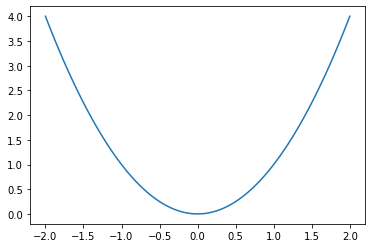

In [ ]:
plt.plot(x, f(x))

La secuencia de pasos que definimos más arriba requiere iniciar eligiendo algún valor al azar de los parámetros y calcular el valor de pérdida:

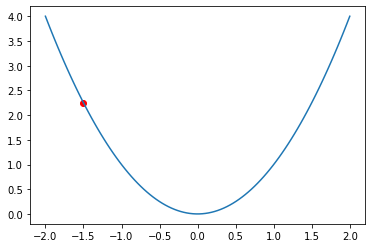

In [ ]:
plt.plot(x, f(x))
plt.scatter(-1.5, f(-1.5), color='red');

Ahora veamos que pasaría si aumentamos o disminuimos el parámetro un poquito para ajustarlo. En este caso sería simplemente tomar la pendiente en un punto en particular:

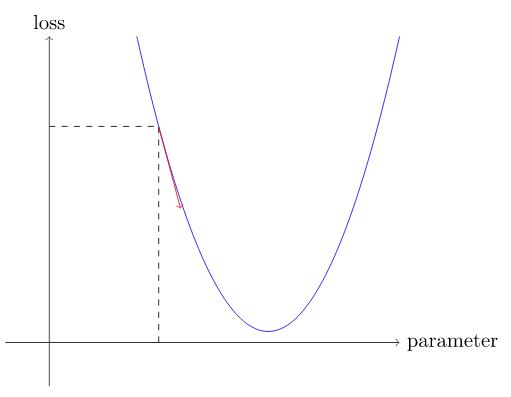

Podemos cambiar el peso un poco en dirección de la pendiente, calcula la pérdida, ajustar nuevamente y repetir el procesos algunas veces más. Eventualmente llegaremos al punto más bajo de la curva:

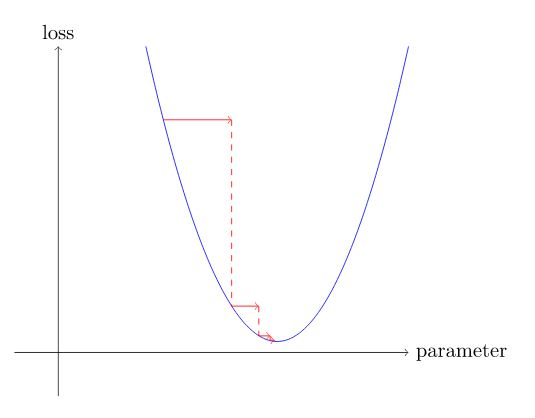

## Calculando Gradientes

La clave entonces es poder calcular los gradientes que nos dirán cuando tenemos que cambiar cada peso para hacer que nuestro modelo mejore.

Pytorch es capaz de calcular de manera automática la derivada de cualquier función. Y lo hace super rápido. Veamos un ejemplo.

Primero seleccionemos un valor tensorial del cual queramos sus gradientes:

In [ ]:
xt = tensor(3.).requires_grad_()

Ojo con el método especial `require_grad_`. Ese es el truco mágico que usamos para decirle a PyTorch que queremos calcular gradientes con respecto a esa variable en ese valor. Básicamente se trata de etiquetar la variable, por lo que PyTorch recordará realizar un seguimiento de cómo calcular los gradientes de cualquier otro cálculo que le pidamos.

Ahora calculemos nuestra función con ese valor. Observemos cómo PyTorch imprime no solo el valor calculado, sino también una nota de que tiene una función de gradiente que usará para calcular nuestros gradientes cuando sea necesario:


In [ ]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Pidamosle entonces a Pytorch que calcule el gradiente:

In [ ]:
yt.backward()

Acá el "backward" hace referencia a *backpropagation*, que es el nombre que se le da al proceso de calcular la derivada de cada capa. Esto es lo que comúnmente se le llama el "paso hacia atrás" de la red neuronal, que es lo opuesto al "paso hacia adelante" que es cuando las activaciones son calculadas. 

Ahora podemos ver los gradientes revisando el atributo grad del tensor:



In [ ]:
xt.grad

tensor(6.)

Recordando algún curso de cálculo que hayamos cursado, sabemos que la derivada de `x**2` es `2*x`, y si tenemos que `x=3`, entonces los gradientes deberían ser `2*3=6`, que fue precisamente el cálculo que hizo Pytorch.

Ahora repitamos los mismos pasos pero para un vector como argumento de la función:

In [ ]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

Vamos a agregar una suma a nuestra función para que pueda procesar un vector (tensor de rango 1) y devolver un escalar (tensor de rango 0):

In [ ]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Nuestros gradientes son `2*xt` como lo esperabamos:

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## Agregando una tasa de aprendizaje

Decidir cómo cambiar nuestros parámetros en función de los valores de los gradientes es una parte importante en deep learning. Casi todos los enfoques comienzan con la idea básica de multiplicar el gradiente por un número pequeño, llamado *tasa de aprendizaje* (Learning Rate, LR). La tasa de aprendizaje suele ser un número entre 0.001 y 0.1, aunque podría ser cualquier cosa. A menudo, los data scientist seleccionan una tasa de aprendizaje simplemente probando algunas y encontrando cuál da como resultado el mejor modelo después del entrenamiento. Una vez que se haya elegido una tasa de aprendizaje, se puede ajustar los parámetros usando esta sencilla función:

`w -= gradient(w)*lr`


Esto se conoce como *escalonamiento* (stepping) de parámetros, usando un *paso optimizador*.

Si elegimos una tasa de aprendizaje que es demasiado baja, puede significar tener que realizar muchos pasos como muestra la siguiente figura.

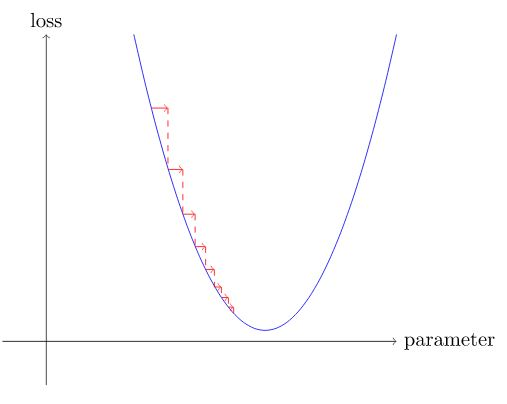

Pero elegir una tasa de aprendizaje muy alta puede ser áun peor, los resultados en la función de pérdida pueden ponerse peores en cada paso:

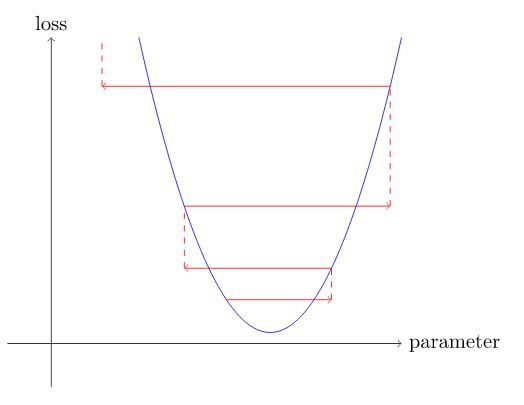

También si la tasa de aprendizaje es muy alta puede saltar de un lado al otro y puede tomar muchos pasos para poder entrenar satisfactoriamente:

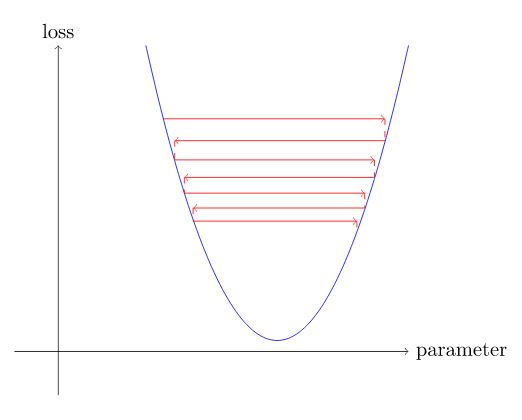

Ahora apliquemos todo esto a un ejemplo de principio a fin.

## Ejemplo completo de cálculo de SGD

Hemos visto como usar los gradientes para encontrar un mínimo. Ahora veamos como usar el SGD para encontrar un mínimo que pueda ser usado para entrenar un modelo para ajustarse mejor a un conjunto de datos.

Empecemos por un ejemplo más simple. Imaginemos que estamos midiendo la velocidad de un carro de una montaña rusa a medida que se va acercando a una subida. Empezaría rápido pero se iría poniendo cada vez más lento a medida que va subiendo. En la cima de la subida tendría su velocidad más baja y luego aceleraría a medida que va en la dirección de bajada. Supongamos que medidos la velocidad cada un segundo por 20 segundos, se vería algo como esto:

In [ ]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

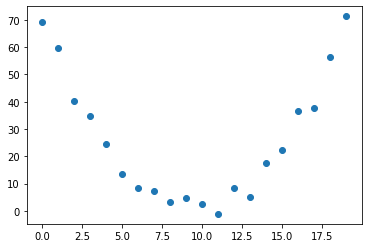

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

Notemos que agregamos un poco de ruido al azar, ya que medir cosas manualmente no es preciso. Eso quiere decir que no es fácil responder la pregunta: ¿Cuál era la velocidad del carro? Usando SGD podemos intentar encontrar una función que se acerque a nuestros valores observados. No podemos considerar todas las funciones posibles, así que asumamos que tendrá una forma cuadrática, es decir, una función de la forma: `a*(time**2)+(b*time)+c`.

Queremos distinguir claramente entre la entrada de la función (el tiempo en que estamos midiendo la velocidad del carro) y sus parámetros (los valores de cuál función cuadrática estamos tratando de ajustar). Así que separaremos la entrada `t` de los parámetros `params` en la definición de la función: 

In [ ]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

En otras palabras: hemos restringido el problema de encontrar la mejor función imaginable que se ajuste a los datos, a encontrar la mejor función *cuadrática*. Esto simplifica enormemente el problema, ya que cada función cuadrática está completamente definida por los tres parámetros `a`,` b` y `c`. Por lo tanto, para encontrar la mejor función cuadrática, solo necesitamos encontrar los mejores valores para `a`,` b` y `c`.

Si podemos resolver este problema para los tres parámetros de una función cuadrática, podremos aplicar el mismo enfoque para otras funciones más complejas con más parámetros, como es el caso de una red neuronal. Primero busquemos los parámetros para `f`, y luego regresaremos y haremos lo mismo para el conjunto de datos MNIST con una red neuronal.

Necesitamos definir primero lo que entendemos por "mejor". Definimos esto precisamente eligiendo una *función de pérdida*, que devolverá un valor basado en una predicción y un objetivo (target), donde los valores más bajos de la función corresponden a predicciones "mejores". Para datos continuos, es común usar *error cuadrático medio*:

In [ ]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

Ahora apliquemos nuestra receta de 7 pasos:

### Paso 1: Inicializar los parámetros

Primero inicializamos los parámetros con valores al azar, y le decimos a Pytorch que queremos seguir sus gradientes usando `requires_grad`:

In [ ]:
params = torch.randn(3).requires_grad_()

In [ ]:
orig_params = params.clone()

### Paso 2: Calcular las predicciones

Lo siguiente es calcular las predicciones:

In [ ]:
preds = f(time, params)

Creemos una función que nos muestre que tan cerca estan nuestras predicciones de los valores objetivos:

In [ ]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

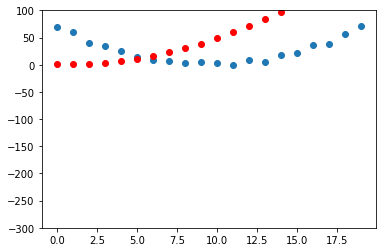

In [ ]:
show_preds(preds)

### Paso 3: Calcular la pérdida

Calculamos el valor de la función de pérdida como:

In [ ]:
loss = mse(preds, speed)
loss

tensor(66.3920, grad_fn=<SqrtBackward>)

El objetivo entonces es mejorar este valor, para hacer eso necesitamos conocer los gradientes.

### Paso 4: Calcular los gradientes

El siguiente paso es calcular los gradientes, es decir, calcular una aproximación de cuánto deberían variar los parámetros:

In [ ]:
loss.backward()
params.grad

tensor([154.9486,   9.9169,   0.5355])

In [ ]:
params.grad * 1e-5

tensor([1.5495e-03, 9.9169e-05, 5.3550e-06])

Podemos usar estos gradientes para mejorar nuestros parámetros. Necesitamos elegir una tasa de aprendizaje:

In [ ]:
params

tensor([ 0.5418, -0.6860,  1.2628], requires_grad=True)

### Paso 5: Ajustar los pesos (Step)

Necesitamos actualizar los parámetros usando los gradientes que recién calculamos:

In [ ]:
lr = 1e-3
params.data -= lr * params.grad.data
params.grad = None

Para entender esto tenemos que hacer un poco de memoria. Para calcular el gradiante tenemos que llamar a `backward` sobre `loss`. Pero esta función `loss` fue calculada usando la función `mse`, la cual toma el vector `preds` como entrada, el que fue calculado usando `f` tomando como entrada a `params`, el cual es el objeto al que originalmente lo "etiquetamos" con `required_grads_`. Eso es lo que finalmente nos deja llamar a  `backward` en `loss`. Esta cadena de llamadas de funciones representa la composición matemática de funciones, lo que permite a Pytorch usar regla de la cadena para calcular los gradientes.

Veamos si la pérdida mejoró:

In [ ]:
preds = f(time,params)
mse(preds, speed)

tensor(43.4489, grad_fn=<SqrtBackward>)

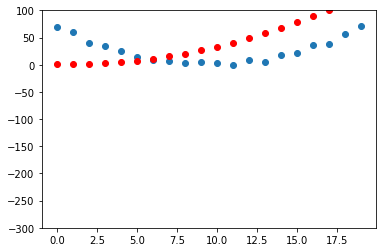

In [ ]:
show_preds(preds)

Necesitamos repetir el proceso algunas veces, por lo que crearemos una función que realice un paso:

In [ ]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

### Paso 6: Repetir el proceso

Ahora lo que toca es iterar en el ciclo de mejoras, con la idea de llegar a un resultado:

In [ ]:
for i in range(10): apply_step(params)

43.44894790649414
28.252641677856445
25.421953201293945
25.421804428100586
25.421655654907227
25.421506881713867
25.421356201171875
25.421207427978516
25.421058654785156
25.42091178894043


¡La pérdida está disminuyendo! Pero mirar solo estos números de pérdida disfraza el hecho de que cada iteración representa una función cuadrática completamente diferente que se está probando, en el camino a encontrar la mejor función cuadrática posible. Podemos ver este proceso visualmente si, en lugar de imprimir la función de pérdida, graficamos la función cuadrática en cada paso. Luego podemos ver cómo se va acecrcando a la mejor función cuadrática posible para nuestros datos:

In [ ]:
params = orig_params.detach().requires_grad_()

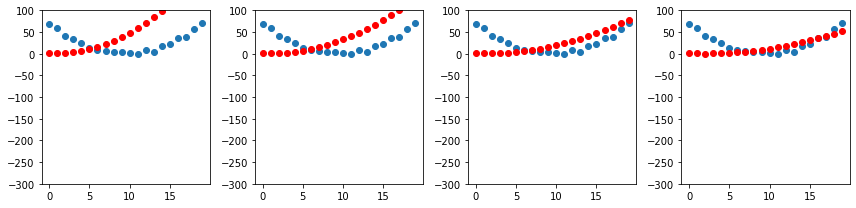

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### Paso 7: Detenerse

Decidimos de manera arbitraria parar luego de 10 épocas. En la práctica podemos mirar la pérdida de entrenamiento y validación para decidir cuando parar.

### Resumiendo el SGD

Resumiendo: en un principio los pesos de nuestro modelo pueden ser aleatorios (entrenamiento *desde cero*) o provenir de un modelo previamente entrenado (*transferencia de aprendizaje*). En el primer caso, la salida que obtendremos de nuestras entradas no tendrá nada que ver con lo que queremos, e incluso en el segundo caso es muy probable que el modelo preentrenado no sea muy bueno en la tarea específica que estamos enfrentando. Entonces el modelo necesitará *aprender* mejores pesos.

Comenzamos comparando los resultados que nos da el modelo con nuestros valores objetivos (ya que hemos etiquetado los datos sabemos qué resultado debe dar el modelo) usando una *función de pérdida*, que devuelve un valor el cual queremos hacer lo más bajo posible mediante la mejora de nuestros pesos. Para hacer esto, tomamos algunos elementos de datos (como imágenes) del conjunto de entrenamiento y los alimentamos a nuestro modelo. Comparamos los objetivos correspondientes usando nuestra función de pérdida, y la puntuación que obtenemos nos dice qué tan equivocadas fueron nuestras predicciones. Luego cambiamos un poco los pesos para hacerlo un poco mejor.

Para saber cómo cambiar los pesos para mejorar un poco el valor de la función de pérdida, usamos herramientas de cálculo para encontrar los *gradientes* (¡Y es ahí donde PyTorch lo hace todo por nosotros!). Usamos la magnitud del gradiente (es decir, la inclinación de la pendiente) para decirnos qué tan grande es el paso que debemos dar; específicamente multiplicamos el gradiente por un número que elegimos llamado *tasa de aprendizaje* para decidir el tamaño del paso. Luego *iteramos* hasta llegar al mínimo, que será nuestro resultado deseado y entonces podemos *detenernos*.

Todo lo que acabamos de ver se puede traspasar directamente al conjunto de datos MNIST, excepto la función de pérdida. Veamos ahora cómo podemos definir un buen objetivo para el entrenamiento.

## La función de pérdida para MNIST

Tenemos nuestras variables independientes `x` que son las imágenes mismas. Las concatenaremos en un solo tensor, cambiandolas desde una lista de matrices (tensor de rango 3) a una lista de vectores (tensor de rango 2). Podemos hacer eso usando `view`, que es el método de Pytorch para cambiar la forma de un tensor sin cambiar su contenido. `-1` es un parámetro especial de `view` que significa "hacer el eje lo suficientemente grande como para abarcar todos los datos":

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Necesitamos una etiqueta para cada imagen. Usaremos el valor `1` para los 3 y `0` para los 7.

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

Un `Dataset` en Pytorch requiere que retorne una tupla `(x,y)` cuando se indexe. Con ayuda de la función `zip` (combinada con `list`) podemos obtenerlo fácilmente.

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Ahora necesitamos un peso para cada pixel, inicializado al azar.

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

La función `weights*pixels` no será suficientemente flexible, es siempre igual a 0 cuando los pixeles son iguales a 0. Recordemos que la fórmula matemática para un recta es `y=w*x+b`, necesitamos esa `b`. Lo inicializaremos al azar igual:

In [ ]:
bias = init_params(1)

En las redes neuronales al `w` de la ecuación `y=w*x+b` se le llama *pesos* y a la `b` se le llama *sesgo* (bias). Juntos construyen lo que se le llamá parámetros. 

Ahora podemos calcular la predicción para una imagen:

In [ ]:
(train_x[0]*weights.T).sum() + bias

tensor([0.5066], grad_fn=<AddBackward0>)

Si hicieramos un loop `for` para calcular la predicción para cada imagen solo usando Python, tendríamos un proceso que se demoraría mucho. Esto debido a que los loops de Python no corren en GPU, así que necesitaremos representar el cálculo de una manera matricial.

En Python la multiplicación matricial se representa con el operador `@`.

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[  0.5066],
        [ -3.6172],
        [-18.3284],
        ...,
        [ -6.6502],
        [-22.8366],
        [ -3.1323]], grad_fn=<AddBackward0>)

El primer elemento es el que ya habíamos calculado anteriormente. Esta ecuación de `batch@weights + bias` es una de las expresiones fundamentales para cualquier red neuronal.

Revisemos nuestro desempeño. Para decidir si la salida representa un 3 o un 7, podemos revisar si el valor es mayor que 0.5, por lo que la exactitud del modelo para cada elemento puede ser calculada como:

In [ ]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [ ]:
corrects.float().mean().item()

0.500484049320221

Ahora veamos que cambia en la exactitud si cambiamos ligeramente los pesos:

In [ ]:
weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5009680390357971

Como hemos visto necesitamos gradientes para mejorar nuestro modelo usando SGD, y para calcular gradientes necesitamos alguna *función de pérdida* que represente qué tan bueno es nuestro modelo. Esto se debe a que los gradientes son una medida de cómo cambia esa función de pérdida debido a pequeños ajustes en los pesos.

Entonces debemos encontrar esa función de pérdida. El enfoque obvio sería utilizar la exactitud (nuestra métrica) también como nuestra función de pérdida. En este caso calcularíamos nuestra predicción para cada imagen, recopilaríamos estos valores para calcular una exactitud general y luego calcularíamos los gradientes de cada peso con respecto a esa exactitud general.

Desafortunadamente tenemos un problema técnico importante. El gradiente de una función es su *pendiente*, que se puede definir como cuánto sube o baja el valor de la función, dividido por cuánto cambiamos la entrada. Podemos escribir esto matemáticamente como: `(y_new - y_old) / (x_new - x_old)`. Esto nos da una buena aproximación del gradiente cuando `x_new` es muy similar a` x_old`, lo que significa que su resta es muy pequeña. Pero la exactitud solo cambiaría cuando una predicción cambia de 3 a 7, o viceversa. El problema es que un pequeño cambio en los pesos de `x_old` a` x_new` probablemente no hará que cambie ninguna predicción, por lo que `(y_new - y_old)` casi siempre será 0. En otras palabras, el gradiente es 0 en casi en cualquier parte.

Un cambio muy pequeño en el valor de un peso a menudo no cambiará la exactitud en absoluto. Esto significa que no es útil usar la exactitud como una función de pérdida; si lo hacemos, la mayoría de las veces nuestros gradientes serán 0 y el modelo no podrá aprender.

Necesitamos una función de pérdida que, cuando nuestros pesos den como resultado predicciones ligeramente mejores, nos de una pérdida ligeramente mejor. Entonces, ¿cómo se ve exactamente una "predicción ligeramente mejor"? En este caso significa que si la respuesta correcta es un 3 la puntuación es un poco más alta, o si la respuesta correcta es un 7 la puntuación es un poco más baja.

Escribamos esa función ahora.

La función de pérdida no recibe las imágenes en sí, sino que las predicciones del modelo. Hagamos un argumento, `prds`, de valores entre 0 y 1, donde cada valor es la predicción de que una imagen es un 3. Es un vector (es decir, un tensor de rango 1), indexado sobre las imágenes.

El propósito de la función de pérdida es medir la diferencia entre los valores predichos y los valores verdaderos, es decir, los objetivos (también conocidos como etiquetas). Hagamos otro argumento, `trgts`, con valores de 0 o 1 que indica si una imagen es realmente un 3 o no. También es un vector (es decir, otro tensor de rango 1), indexado sobre las imágenes.

Entonces, supongamos que tenemos tres imágenes que sabemos que son un 3, un 7 y un 3. Y suponga que nuestro modelo predijo con alta confianza (`0.9`) que la primera era un 3, con una ligera confianza (`0.4`) que el segundo era un 7, y con bastante confianza (`0.2`), pero incorrectamente, que el último era un 7. Esto significaría que nuestra función de pérdida recibiría estos valores como entradas:

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Acá un primer intento de la función de pérdida que mida la distancia entre las predicciones y las etiquetas:

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

Estamos usando una nueva función: `torch.where(a,b,c)`. Equivale a lo mismo que hacer `[b[i] if a[i] else c[i] for i in range(len(a))]` pero que funciona en tensores y por ende a velocidad de GPU. Esta función medirá que tanta distancia tiene cada predicción de un 1 si debería ser un 1, y que tan distante está de 9 si la predicción debiera ser un 0. Luego toma el promedio de todas esas distancias.

Probemos con nuestros `prds` y `trgts`:

In [ ]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

Podemos ver que la función retorna valores más bajos cuando las predicciones son más cercanas a la etiqueta. En Pytorch siempre se asume que un valor más bajo de pérdida es mejor. Dado que necesitamos un escalar para la pérdida final, `mnist_loss` toma el promedio del tensor anterior.

In [ ]:
mnist_loss(prds,trgts)

tensor(0.4333)

Como ejemplo cambiemos una predicción para la etiqueta "falsa" desde `0.2` a `0.8`. La pérdida baja por lo que nos indicaría que tenemos mejores predicciones:

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

Un problema con esta `mnist_loss` es que está definida de forma que asume que las predicciones siempre están entre 0 y 1. Tenemos que asegurarnos que ese siempre sea el caso.

### Sigmoide

La función sigmoid siempre entrega números entre 0 y 1. Se define así:

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Pytorch define una versión acelerada para que la podamos usar. Es una función muy importante en deep learning ya que tenemos que estar constantemente seguros que los valores estan entre 0 y 1. Se ve de la siguiente forma:

In [ ]:
x = tensor(np.linspace(-4, 4, 100))

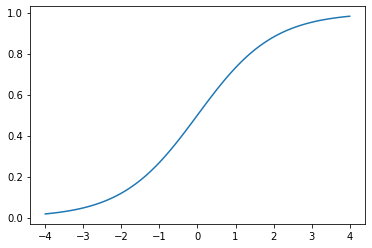

In [ ]:
plt.plot(x, torch.sigmoid(x))

Como podemos ver toma cualquier valor de entrada, ya sea positivo o negativo, y lo suaviza en un valor de salida entre 0 y 1. Es una curva sueva que siempre va hacia arriba, lo que hace más fácil para el SGD encontrar gradientes significativos.

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Ahora podemos estar seguros de que nuestra función de pérdida funcionará, incluso si las predicciones no están entre 0 y 1. Todo lo que se requiere es que una predicción más alta corresponda a una confianza más alta que una imagen es un 3.

Habiendo definido una función de pérdida, ahora es un buen momento para recapitular por qué hicimos esto. Después de todo, ya teníamos una métrica, que era la exactitud general. Entonces, ¿por qué definimos una función de pérdida?

La diferencia clave es que la métrica impulsa la comprensión humana y la pérdida impulsa el aprendizaje automatizado. Para impulsar el aprendizaje automatizado, la pérdida debe ser una función que tenga una derivada significativa. No puede tener grandes secciones planas y grandes saltos, sino que debe ser razonablemente suave. Es por eso que diseñamos una función de pérdida que respondería a pequeños cambios en el nivel de confianza. Este requisito significa que a veces realmente no refleja exactamente lo que estamos tratando de lograr, sino que es más bien un compromiso entre nuestro objetivo real y una función que se puede optimizar usando su gradiente. La función de pérdida se calcula para cada elemento en nuestro conjunto de datos, y luego, al final de una época, todos los valores de pérdida se promedian y se informa la media general para la época.

Las métricas, por otro lado, son los números que realmente nos importan. Estos son los valores que se imprimen al final de cada época que nos dicen cómo está realmente nuestro modelo. Es importante que aprendamos a centrarnos en estas métricas, en lugar de en la pérdida, al juzgar el rendimiento de un modelo.